In [ ]:
# importing libraries
!pip install kaggle
from google.colab import files
import numpy as np
import pandas as pd
import os

import requests
from PIL import Image
from io import BytesIO

import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt

In [ ]:
#Bringing the dataset
from google.colab import drive
drive.mount('/content/drive')
#! mkdir ~/.kaggle
os.environ['KAGGLE_USERNAME'] = "hanviksuruboyina"
os.environ['KAGGLE_KEY'] = "b8f48ef46400e2f5a559ada21f2cc402"
!cp /content/drive/MyDrive/ML/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download vitaliykinakh/guie-laion5b-dataset
! unzip guie-laion5b-dataset.zip

Mounted at /content/drive
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
 51% 25.0M/49.4M [00:00<00:00, 72.2MB/s]
100% 49.4M/49.4M [00:00<00:00, 114MB/s] 
Archive:  guie-laion5b-dataset.zip
  inflating: GUIE_laion5b_dataset_en.json  


In [ ]:
#json to csv
data_json = pd.read_json('GUIE_laion5b_dataset_en.json')
data_json.to_csv('data.csv', index=False)
data = pd.read_csv('data.csv')
print(data.head(5))

                                             caption  \
0                                         gladiatore   
1  Gladiator is listed (or ranked) 4 on the list ...   
2             are-you-not-entertained-w-text-720x396   
3  "Russell Crowe em ""Gladiador"" - ©Dreamworks/...   
4  Portrait of smiling boy in the temple of Apoll...   

                                                 url          id  similarity  \
0  https://libreriamo.it/wp-content/uploads/2020/...  4748272869    0.516147   
1  https://imgix.ranker.com/user_node_img/54/1075...  2784821276    0.513879   
2  https://traditionalpolytheist.files.wordpress....  2386885741    0.508544   
3  https://conteudo.imguol.com.br/c/entreteniment...   841845904    0.507340   
4  https://thumbs.dreamstime.com/b/portrait-smili...  1892934610    0.506108   

                            prompt category  \
0  meme "Are you not entertained?"     meme   
1  meme "Are you not entertained?"     meme   
2  meme "Are you not entertained?"     me

In [ ]:
# to find the names of categories
def categories(category):
  column_values = data[category]
  unique_values = column_values.unique()
  unique_column_names = [col.split(':')[0] for col in unique_values]
  #print(unique_column_names)
  #print(len(unique_column_names))
  return unique_column_names

print(categories('category'))
print(categories('prompt'))

def number_rows_category(word, category):
  matching_rows = data[data[category].str.contains(word, case=False)]
  num_rows = matching_rows.shape[0]
  print(num_rows)

number_rows_category('car', 'category')

for i in range (0,9):
  number_rows_category(categories('category')[i], 'category')
print(categories('category'))

['meme', 'toys', 'furniture', 'car', 'food and packaged goods', 'clothes', 'storefronts', 'paintings', 'landmark']
['meme "Are you not entertained?"', 'meme Scumbag Steve', 'meme Demotivational posters', 'meme "All Your Base Are Belong to Us"', 'meme Chuck Norris Facts', 'meme "Thanks, Obama"', 'meme Success Kid', 'meme "Fuck it, we\'ll do it live!"', 'Keep Calm and Carry On', 'meme Numa Numa', 'meme The Most Interesting Man', 'meme "Khaaaaaaaaaan!!!!"', 'meme "Imma let you finish"', 'meme Michael Jackson eating popcorn', 'meme Harambe', 'meme Keyboard Cat', 'meme James Van Der Beek crying', 'meme Ceiling Cat', 'meme #Winning', 'meme woman yelling at a cat', 'meme "Netflix and chill"', 'meme pepe frog', 'meme "Gangnam Style"', 'meme Shirtless Putin', 'meme Kermit', 'meme Doge', 'meme Smash Mouth\'s "All Star"', 'meme Distracted Boyfriend', 'meme Nigerian prince', 'meme The Honey Badger', 'meme trollface', 'meme Bert Is Evil', 'meme Trollface', 'meme LOLcats', 'meme Keep Calm', 'meme OB

In [ ]:
data = data.drop('id', axis=1) # to remove the id column as it is not useful
data = data.drop('caption', axis=1) # to remove the caption column as it is not useful
data = data.drop('caption_en', axis=1)
data = data.drop('similarity', axis=1)

In [ ]:
data

,url,prompt,category
0,https://libreriamo.it/wp-content/uploads/2020/...,"meme ""Are you not entertained?""",meme
1,https://imgix.ranker.com/user_node_img/54/1075...,"meme ""Are you not entertained?""",meme
2,https://traditionalpolytheist.files.wordpress....,"meme ""Are you not entertained?""",meme
3,https://conteudo.imguol.com.br/c/entreteniment...,"meme ""Are you not entertained?""",meme
4,https://thumbs.dreamstime.com/b/portrait-smili...,"meme ""Are you not entertained?""",meme
...,...,...,...
498087,https://static2.tripoto.com/media/filter/nt/im...,landmark Mount Everest,landmark
498088,https://images.pond5.com/peaks-near-gorak-shep...,landmark Mount Everest,landmark
498089,https://i1.vpoxod.ru/route-photo/38/c7/54/fb/4...,landmark Mount Everest,landmark
498090,https://images.centrometeoitaliano.it/wp-conte...,landmark Mount Everest,landmark


In [ ]:
df = pd.DataFrame()

In [ ]:
for i in range (len(categories('category'))):
  print(i)
  items_with_specific_label = data[data['category'] == categories('category')[i]]
  items_with_specific_label = items_with_specific_label.sample(frac=1, random_state=42)
  items_with_specific_label = items_with_specific_label.head(10)
  df = df.append(items_with_specific_label)
df = df.reset_index(drop=True)

0
1


<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)
<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)
<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)


2
3
4


<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)
<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)
<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)


5
6
7


<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)
<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)


8


<ipython-input-8-022ee89892df>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(items_with_specific_label)


In [ ]:
df

,url,prompt,category
0,https://static.wixstatic.com/media/039af8_8b6f...,meme Bert Is Evil,meme
1,https://i.imgflip.com/2vo3mr.jpg,meme #FirstWorldProblems,meme
2,https://wiki.blogs.com/photos/uncategorized/20...,"meme ""Khaaaaaaaaaan!!!!""",meme
3,https://i.pinimg.com/200x150/36/c9/d5/36c9d5bb...,meme Keep Calm,meme
4,http://cdn.salemweb.net/godtube/2011/09/16/337...,"meme ""Fuck it, we'll do it live!""",meme
...,...,...,...
85,https://freedomdestinations.co.uk/wp-content/u...,landmark Fairmont Le Château Frontenac,landmark
86,https://cdn.vox-cdn.com/thumbor/ZUQmkwGVccNDMY...,landmark Mexico City Cathedral,landmark
87,https://pic.pimg.tw/jcp1223/1387283539-2192754...,landmark Taipei 101,landmark
88,https://thumbs.dreamstime.com/t/%D0%B1%D0%B0%D...,landmark CN Tower,landmark


In [ ]:
size = df.shape[0]
image_array = np.zeros((size,), dtype=object)  # Use object dtype to store arrays of varying sizes
image_array.shape

(90,)

In [ ]:
count = 0
for i in range(size):
    urls = df.loc[i, 'url']

    try:
        print(i)
        response = requests.get(urls)
        response.raise_for_status()  # Check for any HTTP request errors

        # Read the image data from the response content
        image_data = response.content

        # Create a PIL image object from the image data
        image = Image.open(BytesIO(image_data))
        image = image.resize((224, 224))

        # Convert the PIL image to a NumPy array
        image_np = np.array(image)

        # Assign the NumPy array to the appropriate index in image_array
        image_array[count] = image_np
        count = count + 1

    except requests.exceptions.RequestException as err:
        df = df.drop(i)
        print(f"Error occurred for URL {urls}: {err}")

    except (IOError, ValueError) as err:
        df = df.drop(i)
        print(f"Error occurred while processing image {i}: {err}")


0
1
2
Error occurred for URL https://wiki.blogs.com/photos/uncategorized/2007/04/15/cheeeese.jpg: 403 Client Error: Forbidden for url: https://wiki.blogs.com/photos/uncategorized/2007/04/15/cheeeese.jpg
3
4
5
6
7
8
9
10
11
Error occurred for URL https://www.darice.com/Content/Images/ProductImages/XL/Main/9163-46.jpg: HTTPSConnectionPool(host='www.darice.com', port=443): Max retries exceeded with url: /Content/Images/ProductImages/XL/Main/9163-46.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7dcbd0970f40>: Failed to establish a new connection: [Errno -2] Name or service not known'))
12
13
Error occurred for URL https://www.tobar.fr/media/catalog/product/cache/3/small_image/450x450/9df78eab33525d08d6e5fb8d27136e95/E46113_800.jpg: 404 Client Error: Not Found for url: https://www.tobar.fr/media/catalog/product/cache/3/small_image/450x450/9df78eab33525d08d6e5fb8d27136e95/E46113_800.jpg
14
15
16
Error occurred for URL https://cdn1.tedsby.com/tb/medium/sto

In [ ]:
df = df.reset_index(drop=True)
image_array = image_array[:count]
df['image_array'] = image_array

In [ ]:
df

,url,prompt,category,image_array
0,https://static.wixstatic.com/media/039af8_8b6f...,meme Bert Is Evil,meme,"[[[241, 241, 232], [245, 243, 234], [235, 231,..."
1,https://i.imgflip.com/2vo3mr.jpg,meme #FirstWorldProblems,meme,"[[[194, 192, 171], [194, 192, 171], [193, 192,..."
2,https://i.pinimg.com/200x150/36/c9/d5/36c9d5bb...,meme Keep Calm,meme,"[[[57, 27, 3], [63, 33, 9], [63, 32, 7], [57, ..."
3,http://cdn.salemweb.net/godtube/2011/09/16/337...,"meme ""Fuck it, we'll do it live!""",meme,"[[[128, 161, 178], [154, 188, 205], [156, 188,..."
4,https://thumbs.dreamstime.com/t/le-mari-et-l-%...,"meme ""Fuck it, we'll do it live!""",meme,"[[[133, 111, 97], [132, 114, 99], [131, 117, 1..."
...,...,...,...,...
71,https://freedomdestinations.co.uk/wp-content/u...,landmark Fairmont Le Château Frontenac,landmark,"[[[175, 156, 126], [175, 158, 129], [178, 161,..."
72,https://cdn.vox-cdn.com/thumbor/ZUQmkwGVccNDMY...,landmark Mexico City Cathedral,landmark,"[[[29, 19, 8], [29, 16, 8], [25, 9, 4], [31, 1..."
73,https://pic.pimg.tw/jcp1223/1387283539-2192754...,landmark Taipei 101,landmark,"[[[114, 76, 11], [104, 68, 9], [93, 58, 10], [..."
74,https://thumbs.dreamstime.com/t/%D0%B1%D0%B0%D...,landmark CN Tower,landmark,"[[[81, 159, 221], [81, 159, 221], [81, 159, 22..."


In [ ]:
num_rows = df.shape[0]

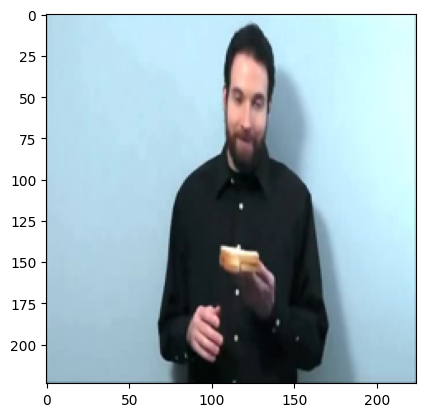

In [ ]:

import matplotlib.pyplot as plt
plt.imshow(image_array[3], cmap='viridis')
#plt.colorbar()

# Display the plot
plt.show()

In [ ]:
df

,url,prompt,category,image_array
0,https://static.wixstatic.com/media/039af8_8b6f...,meme Bert Is Evil,meme,"[[[241, 241, 232], [245, 243, 234], [235, 231,..."
1,https://i.imgflip.com/2vo3mr.jpg,meme #FirstWorldProblems,meme,"[[[194, 192, 171], [194, 192, 171], [193, 192,..."
2,https://i.pinimg.com/200x150/36/c9/d5/36c9d5bb...,meme Keep Calm,meme,"[[[57, 27, 3], [63, 33, 9], [63, 32, 7], [57, ..."
3,http://cdn.salemweb.net/godtube/2011/09/16/337...,"meme ""Fuck it, we'll do it live!""",meme,"[[[128, 161, 178], [154, 188, 205], [156, 188,..."
4,https://thumbs.dreamstime.com/t/le-mari-et-l-%...,"meme ""Fuck it, we'll do it live!""",meme,"[[[133, 111, 97], [132, 114, 99], [131, 117, 1..."
...,...,...,...,...
71,https://freedomdestinations.co.uk/wp-content/u...,landmark Fairmont Le Château Frontenac,landmark,"[[[175, 156, 126], [175, 158, 129], [178, 161,..."
72,https://cdn.vox-cdn.com/thumbor/ZUQmkwGVccNDMY...,landmark Mexico City Cathedral,landmark,"[[[29, 19, 8], [29, 16, 8], [25, 9, 4], [31, 1..."
73,https://pic.pimg.tw/jcp1223/1387283539-2192754...,landmark Taipei 101,landmark,"[[[114, 76, 11], [104, 68, 9], [93, 58, 10], [..."
74,https://thumbs.dreamstime.com/t/%D0%B1%D0%B0%D...,landmark CN Tower,landmark,"[[[81, 159, 221], [81, 159, 221], [81, 159, 22..."


In [ ]:
#TOKENIZER


token_words = ['this', 'is', 'a', 'picture', 'of', 'a']
len_token = len(token_words)

def tokenizer(words):
    unique_tokens = set(words)
    return list(unique_tokens)

for k in range (0, num_rows):
  prompt = df.loc[k, 'prompt']
  prompt = prompt.lower()
  #print(prompt)
  x = prompt.split()
  token_words.extend(x)
  #token_words.append(prompt)
  token_words = tokenizer(token_words)

for k in range (0, num_rows):
  prompt = df.loc[k, 'category']
  prompt = prompt.lower()
  #print(prompt)
  x = prompt.split()
  token_words.extend(x)
  #token_words.append(prompt)
  token_words = tokenizer(token_words)

print(token_words)

['sierra', 'peggy’s', 'fairmont', 'paintings', 'live!"', 'football', 'westminster', 'clothes', 'seoul', 'adam', 'toys', 'rice', 'meme', 'pillow', '1500', 'egg', 'silverado', "men's", 'ball', 'tower', 'beans', 'le', 'kettle', 'point', '101', 'is', 'taipei', 'with', 'cat', 'girl', 'frontenac', 'beach', 'cabinet', 'ring', 'auchan', 'lamp', 'ram', 'michelangelo', 'bondi', 'city', 'cafe', 'lego', 'do', 'chopper', 'chevrolet', '2020', 'abbey', 'square', 'picture', 'curtains', 'stool', 'this', 'canada', 'wolmart', 'it', 'tacoma', 'toy', 'snacks', 'painting', 'suit', 'keep', 'bert', 'the', 'artwork', 'olympia', 'argument', 'night', '"fuck', 'cn', '#firstworldproblems', 'gmc', 'a', 'lisa', 'mona', 'tv', 'happy', '#winning', 'sandro', 'blocks', 'hotdog', 'arnolfini', 'of', 'lidl', 'cathedral', 'umbrella', 'pearl', 'jacket', 'packaged', 'and', 'car', 'pepsi', 'mittens', 'kitchen', 'purse', 'storefronts', 'civic', 'photos', 'creation', 'evil', 'storefront', 'wrap', 'mexico', 'primavera', 'sausages

In [ ]:
len(token_words)

142

In [ ]:
values = []
for i in range (1, len(token_words)+1):
  values.append(i)


In [ ]:
def token(i):
  prompt = df.loc[i, 'prompt']
  prompt = prompt.lower()
  x = prompt.split()
  token_words.extend(x)
  return tokenizer(token_words)

In [ ]:
text_paths = df['prompt'].head(10).tolist()

In [ ]:
(text_paths)


['meme Bert Is Evil',
 'meme #FirstWorldProblems',
 'meme Keep Calm',
 'meme "Fuck it, we\'ll do it live!"',
 'meme "Fuck it, we\'ll do it live!"',
 'meme Rickrolling',
 'meme American Chopper argument',
 'meme #Winning',
 'meme Ceiling Cat',
 'toy doll']

In [ ]:
text_paths = [word.lower() for word in text_paths]

In [ ]:
dataset = text_paths

In [ ]:
# Example vocabulary mapping with "<PAD>" token
vocab = {}
for i in range(len(token_words)):
    key = token_words[i]
    value = values[i]
    vocab[key] = value

# Add the "<PAD>" token to the vocab
vocab["<PAD>"] = 0

sentences_list = text_paths

# Initialize an empty list to store tokenized sentences
tokenized_sentences = []
max_sentence_length = 20
tokenized_sentences_with_padding = []

# Loop through each sentence in the sentences_list
for sentence in sentences_list:
    # Split the sentence into words
    words = sentence.split()
    # Initialize an empty list to store tokens for this sentence
    tokenized_sentence = []
    # Loop through each word in the words list
    for word in words:
        # Convert the word to lowercase
        lowercase_word = word.lower()
        # Check if the lowercase word exists in the vocab dictionary
        if lowercase_word in vocab:
            # If it exists, append its corresponding token to the tokenized_sentence list
            tokenized_sentence.append(vocab[lowercase_word])
    # Add padding to the tokenized_sentence to make its length 25
    tokenized_sentence += [vocab['<PAD>']] * (max_sentence_length - len(tokenized_sentence))
    # Truncate the sentence to the maximum length (in case it's longer than 25)
    tokenized_sentence = tokenized_sentence[:max_sentence_length]
    # Append the tokenized_sentence list to the tokenized_sentences_with_padding list
    tokenized_sentences_with_padding.append(tokenized_sentence)

print(tokenized_sentences_with_padding)
input_tensor = torch.tensor(tokenized_sentences_with_padding, dtype=torch.long)
print(input_tensor.shape)


# Add any missing words from the dataset to the vocab
#for sentence in text_paths:
#    for word in sentence:
#        if word not in vocab:
#            vocab[word] = len(vocab)

# Now convert the dataset to numerical_dataset
#numerical_dataset = [[vocab[word] for word in sentence] for sentence in dataset]

#max_sequence_length = max(len(sentence) for sentence in numerical_dataset)
#padded_numerical_dataset = [sentence + [vocab["<PAD>"]] * (max_sequence_length - len(sentence)) for sentence in numerical_dataset]

#input_tensor = torch.tensor(padded_numerical_dataset, dtype=torch.long)
#print(input_tensor.shape)

mask = (input_tensor != vocab["<PAD>"]).unsqueeze(1).unsqueeze(2)
print(mask.shape)


[[13, 62, 26, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 61, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 68, 132, 108, 43, 55, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 68, 132, 108, 43, 55, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 124, 44, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [13, 137, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [57, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
torch.Size([10, 20])
torch.Size([10, 1, 1, 20])


In [ ]:
mask = mask.float()

tensor([[[[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]],


        [[[1., 1., 0., 0., 0., 0., 0.

In [ ]:
import torch
import torch.nn as nn


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values)  # (N, value_len, embed_size)
        keys = self.keys(keys)  # (N, key_len, embed_size)
        queries = self.queries(query)  # (N, query_len, embed_size)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)


        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out



In [ ]:
src_vocab_size = 1000  # Assuming there are 10,000 unique words in the source vocabulary
#embed_size = 128        # Dimension of word embeddings is 256
embed_size = 196*2
num_layers = 6          # Using 6 Transformer blocks (layers)
heads = 8               # 8 attention heads
forward_expansion = 4   # Factor by which the hidden dimension is expanded in the feed-forward network is 4
dropout = 0.1           # Dropout rate of 0.1 (10%)
max_length = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

#encoder = Encoder(src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length)

In [ ]:
encoder = Encoder(src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length)

In [ ]:
text_output_tensor = encoder(input_tensor, mask)

In [ ]:
text_output_tensor.shape

torch.Size([10, 20, 392])

In [ ]:
text_output_tensor

tensor([[[ 4.8373e-01, -4.0865e-01,  1.8290e-01,  ..., -9.3966e-01,
          -6.3647e-01,  3.6896e-01],
         [-2.2570e-01,  5.4389e-02, -9.6935e-01,  ...,  1.4189e-01,
          -6.0111e-01,  5.5331e-02],
         [ 2.6655e+00,  1.9713e+00, -0.0000e+00,  ..., -3.8898e-01,
          -1.8935e-01, -2.1133e-02],
         ...,
         [-1.8207e-01,  2.2909e+00,  8.4090e-01,  ..., -8.2671e-01,
           1.5485e-01, -3.7554e-01],
         [ 9.9135e-02,  3.0946e-01,  3.5237e-01,  ..., -1.4797e-01,
           2.9978e-01, -2.4990e-01],
         [ 5.3351e-01,  2.9888e-01, -2.5749e-01,  ..., -8.0302e-01,
          -1.9537e-01, -8.8437e-01]],

        [[-2.9763e+00, -3.8492e-01, -3.2973e-01,  ...,  1.5482e-01,
          -1.4199e+00,  0.0000e+00],
         [ 9.8967e-01,  2.1981e+00,  3.1751e-01,  ..., -1.8700e+00,
           2.5706e-02, -2.4527e-01],
         [ 0.0000e+00,  2.8851e+00,  4.9566e-01,  ...,  3.6260e-01,
          -1.7338e-04,  0.0000e+00],
         ...,
         [ 1.0050e+00, -1

In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_size = embed_size
        self.num_patches = (img_size // patch_size) ** 2

        self.projection = nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # (batch_size, embed_size, num_patches, num_patches)
        x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches*num_patches, embed_size)
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        in_channels,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        num_classes,
        max_length,
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.classification_head = nn.Linear(embed_size, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.device = device

    def forward(self, x, mask=None):
        x = self.patch_embedding(x)
        N, num_patches, _ = x.shape

        positions = torch.arange(0, num_patches).expand(N, num_patches).to(self.device)
        x += self.position_embedding(positions)

        for layer in self.layers:
            x = layer(x, x, x, mask)
        #print(x.shape)
        #print(x[:, 0].shape)
        # Take only the first token (CLS token) and pass it through the classification head
        #cls_token = x[:, 0]
        cls_token = x
        cls_token = self.dropout(cls_token)
        logits = self.classification_head(cls_token)

        return logits


In [ ]:
dftemp = df.head(10)

In [ ]:
dftemp

,url,prompt,category,image_array
0,https://static.wixstatic.com/media/039af8_8b6f...,meme Bert Is Evil,meme,"[[[241, 241, 232], [245, 243, 234], [235, 231,..."
1,https://i.imgflip.com/2vo3mr.jpg,meme #FirstWorldProblems,meme,"[[[194, 192, 171], [194, 192, 171], [193, 192,..."
2,https://i.pinimg.com/200x150/36/c9/d5/36c9d5bb...,meme Keep Calm,meme,"[[[57, 27, 3], [63, 33, 9], [63, 32, 7], [57, ..."
3,http://cdn.salemweb.net/godtube/2011/09/16/337...,"meme ""Fuck it, we'll do it live!""",meme,"[[[128, 161, 178], [154, 188, 205], [156, 188,..."
4,https://thumbs.dreamstime.com/t/le-mari-et-l-%...,"meme ""Fuck it, we'll do it live!""",meme,"[[[133, 111, 97], [132, 114, 99], [131, 117, 1..."
5,http://wheresmysammich.com/images/thumbs/47937...,meme Rickrolling,meme,"[[[43, 43, 43], [42, 42, 42], [41, 41, 41], [4..."
6,https://thumbs.dreamstime.com/z/gor%C4%85ce-ro...,meme American Chopper argument,meme,"[[[186, 89, 18], [182, 85, 14], [183, 85, 14],..."
7,https://postila.ru/resize?w=460&src=%2Fdata%2F...,meme #Winning,meme,"[[[254, 254, 254], [254, 254, 254], [254, 254,..."
8,https://thumbs.dreamstime.com/z/toskana-k%C3%B...,meme Ceiling Cat,meme,"[[[201, 191, 181], [199, 189, 179], [199, 189,..."
9,https://cdn.shopify.com/s/files/1/1377/4645/pr...,toy doll,toys,"[[[236, 230, 226], [237, 231, 225], [239, 231,..."


In [ ]:
image_paths = dftemp['image_array'].tolist()

In [ ]:
preprocess = transforms.Compose([
    #transforms.Resize((256, 256)),  # Resize images to a fixed size (e.g., 256x256)
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])
i = 0
preprocessed_images = []
for image_path in image_paths:
    img = image_paths[i]
    img = preprocess(img)
    preprocessed_images.append(img)
    i = i+1


stacked_images_tensor = torch.stack(preprocessed_images)

In [ ]:
i

10

In [ ]:
stacked_images_tensor.shape

torch.Size([10, 3, 224, 224])

In [ ]:
stacked_images_tensor.shape

torch.Size([10, 3, 224, 224])

In [ ]:

import torch
import torch.nn as nn

# Example input image size and patch size
img_size = 224
patch_size = 16
in_channels = 3  # Assuming RGB images

# Vision Transformer parameters
embed_size = 256
num_layers = 6
heads = 8
dropout = 0.1
num_classes = 40  # Replace this with the number of classes in your classification task
#num_classes = 142*128
max_length = (img_size // patch_size) ** 2 + 1  # +1 for the CLS token

# Create 10 random input images as a batch (batch_size=10)
batch_size = 10
input_images = stacked_images_tensor

# Create the VisionTransformer model
model = VisionTransformer(
    img_size=img_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_size=embed_size,
    num_layers=num_layers,
    heads=heads,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    forward_expansion=4,  # You can adjust this value if needed
    dropout=dropout,
    num_classes=num_classes,
    max_length=max_length,
)


# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Forward pass to get the output tensor
with torch.no_grad():
    model.eval()
    input_images = input_images.to(device)
    image_output_tensor = model(input_images)

print(image_output_tensor.shape)

torch.Size([10, 196, 40])


tensor([[[-0.7285, -0.8557,  1.0983,  ...,  0.1058, -0.0040,  1.4328],
         [-0.4563, -0.4228, -0.5972,  ...,  0.1845, -0.8843,  0.2663],
         [-0.2212, -0.6337, -0.8496,  ...,  0.1360,  0.0905,  0.1873],
         ...,
         [ 0.2514, -0.3927, -0.2670,  ...,  0.2568,  0.3627, -0.2634],
         [-0.1293, -0.1820,  0.5785,  ...,  1.2420, -0.3475, -0.2039],
         [-0.3908, -0.7066, -0.2163,  ...,  0.3405,  0.4511,  0.4615]],

        [[-0.8022, -0.9944,  1.1772,  ..., -0.0739, -0.0947,  1.4439],
         [-0.5821, -0.3609, -0.5386,  ...,  0.1215, -1.1517,  0.3308],
         [-0.5760, -0.3206, -1.0060,  ..., -0.2443, -0.0244,  0.2794],
         ...,
         [ 0.0846, -0.4143, -0.1419,  ...,  0.0778,  0.1169,  0.0361],
         [-0.3477,  0.0871,  0.6260,  ...,  1.2359,  0.2867, -0.0160],
         [-0.3261, -0.2824, -0.2798,  ...,  0.3872,  0.6690,  0.4935]],

        [[-0.6840, -0.1908,  0.5949,  ..., -0.8000, -0.6878,  0.7443],
         [-0.5703,  0.0104, -1.0118,  ..., -0

In [ ]:
def image_tens():
    # Move the model to the appropriate device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Forward pass to get the output tensor
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode (important for dropout layers)
        input_images = input_images.to(device)
        image_output_tensor = model(input_images)

    #print(image_output_tensor.shape)  # Output should be torch.Size([10, 10, 256])
    return(image_output_tensor)


* For text = text_output_tensor


* For images = image_output_tensor

In [ ]:
def resize_tensor(text_output_tensor):
  x_size = text_output_tensor.size(1)
  y_size = text_output_tensor.size(2)

  z_size = x_size * y_size

  text_output_tensor = text_output_tensor.view(10, z_size)
  return text_output_tensor

In [ ]:
print(text_output_tensor.shape)
print(image_output_tensor.shape)

torch.Size([10, 20, 392])
torch.Size([10, 196, 40])


In [ ]:
temp = 7840
text_output_tensor1 = text_output_tensor.view(10, temp)
image_output_tensor1 = image_output_tensor.view(10, temp)
#image_output_tensor = image_output_tensor.transpose(0, 1)

In [ ]:
print(text_output_tensor1.shape)
print(image_output_tensor1.shape)

torch.Size([10, 7840])
torch.Size([10, 7840])


In [ ]:
text_output_tensor1

tensor([[ 0.4837, -0.4086,  0.1829,  ..., -0.8030, -0.1954, -0.8844],
        [-2.9763, -0.3849, -0.3297,  ..., -0.0000, -2.2630, -0.1113],
        [ 0.0554,  0.6807,  0.0592,  ..., -0.4407, -0.0359,  0.8325],
        ...,
        [ 0.8149, -0.4646,  0.9473,  ...,  3.0940,  0.0256, -2.8862],
        [ 0.4620, -0.5134,  0.3801,  ...,  0.5175,  0.1402,  0.0000],
        [ 0.0000,  0.5092,  0.4142,  ...,  0.5119, -0.8898,  0.7881]],
       grad_fn=<ViewBackward0>)

In [ ]:
image_output_tensor1

tensor([[-0.7285, -0.8557,  1.0983,  ...,  0.3405,  0.4511,  0.4615],
        [-0.8022, -0.9944,  1.1772,  ...,  0.3872,  0.6690,  0.4935],
        [-0.6840, -0.1908,  0.5949,  ..., -0.9445, -0.1770, -0.4517],
        ...,
        [-0.6945, -0.7842,  0.7919,  ...,  0.4733,  0.4529,  0.2762],
        [-0.8695, -0.8859,  0.9548,  ..., -0.4495,  0.3975, -0.1174],
        [-0.7747, -0.9535,  0.9363,  ...,  0.2130,  0.4391,  0.5093]])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Assuming you have a custom image and text encoder models
# Replace these with your actual models
#image_encoder = model
#text_encoder = encoder

class CLIPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = model
        self.text_encoder = encoder

    def forward(self, input_images, input_tensor, mask):
        # Getting Image and Text Features
        image_features = self.image_encoder(input_images)
        text_features = self.text_encoder(input_tensor, mask)

        batch_size = input_images.size(0)
        temp = 7840
        text_features_flat = text_features.view(batch_size, temp)
        image_features_flat = image_features.view(batch_size, temp)

        # to trnspose
        image_features_flat = image_features_flat.transpose(0, 1)

        # Matrix multiplication
        #predicted_matrix = torch.matmul(text_features_flat, image_features_flat)
        #print(predicted_matrix.shape)
        #return predicted_matrix
        return text_features_flat, image_features_flat


In [ ]:
def pred_matrix(text_features_flat, image_features_flat):
  predicted_matrix = torch.matmul(text_features_flat, image_features_flat)
  #print(predicted_matrix)
  return predicted_matrix

In [ ]:
my_model = CLIPModel().to(device)
#predicted_matrix = my_model(input_images, input_tensor, mask)

In [ ]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(my_model.parameters(), lr=0.01)

In [ ]:
epochs = 15

In [ ]:
batch_size

10

In [ ]:
targets = 1000*torch.eye(batch_size)

In [ ]:
targets

tensor([[1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0., 1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0., 1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0., 1000.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1000.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1000.]])

In [ ]:
my_data = (input_images, input_tensor, mask)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define your cross_entropy function
def cross_entropy(preds, targets, reduction='mean'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

criterion = nn.MSELoss()

# Assuming you have a training loop
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_model.to(device)

for epoch in range(epochs):
        #my_model.train()  # Set the model to training mode
    #for batch_idx, (input_images, input_tensor, mask, targets) in enumerate(train_loader):
        # Move data to the device
        input_images = input_images.to(device)
        input_tensor = input_tensor.to(device)
        mask = mask.to(device)
        targets = targets.to(device)

        # Forward pass to get predictions
        a, b = my_model(input_images, input_tensor, mask)
        print(a,b)
        scores = pred_matrix(a, b)

        ground_truth_matrix = 1000*torch.eye(10)  # Identity matrix of size (10, 10)

        # Calculate the mean squared error loss
        #loss = F.mse_loss(scores, ground_truth_matrix)
        # Compute the cross-entropy loss
        loss = cross_entropy(scores, targets, reduction='mean')
        #loss = criterion(scores, targets)
        #print(loss.item())  # Print the loss for each batch


        # Perform backpropagation and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch:', epoch)
        #print(scores)
        my_model.train()

# After training, you can switch the model to evaluation mode before making predictions.
my_model.eval()


tensor([[-1.7129,  0.9559,  0.6576,  ..., -0.6016, -0.2351, -0.0040],
        [-1.7129,  0.9559,  0.6576,  ..., -0.6016, -0.2351, -0.0040],
        [-1.7129,  0.9559,  0.6576,  ..., -0.6016, -0.2351, -0.0040],
        ...,
        [-1.7129,  0.9559,  0.6576,  ..., -0.6016, -0.2351, -0.0040],
        [-1.7129,  0.9559,  0.6576,  ..., -0.6016, -0.2351, -0.0040],
        [-1.7129,  0.9559,  0.6576,  ..., -0.6016, -0.2351, -0.0040]],
       grad_fn=<ViewBackward0>) tensor([[-0.5899, -0.5899, -0.5899,  ..., -0.5899, -0.5899, -0.5899],
        [ 0.4548,  0.4548,  0.4548,  ...,  0.4548,  0.4548,  0.4548],
        [-0.4351, -0.4351, -0.4351,  ..., -0.4351, -0.4351, -0.4351],
        ...,
        [-0.3597, -0.3597, -0.3597,  ..., -0.3597, -0.3597, -0.3597],
        [ 0.3833,  0.3833,  0.3833,  ...,  0.3833,  0.3833,  0.3833],
        [ 1.0119,  1.0119,  1.0119,  ...,  1.0119,  1.0119,  1.0119]],
       grad_fn=<TransposeBackward0>)
Epoch: 0
tensor([[-1.9772,  0.8829,  0.8450,  ..., -0.5467, -0.

CLIPModel(
  (image_encoder): VisionTransformer(
    (patch_embedding): PatchEmbedding(
      (projection): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    )
    (position_embedding): Embedding(197, 256)
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): SelfAttention(
          (values): Linear(in_features=256, out_features=256, bias=True)
          (keys): Linear(in_features=256, out_features=256, bias=True)
          (queries): Linear(in_features=256, out_features=256, bias=True)
          (fc_out): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
        (dropout): Dropout(p=0.1, inplac

In [ ]:
print(scores)

tensor([[1330.4524, 1274.8289, 1288.9905, 1289.8621, 1301.0552, 1252.7659,
         1291.7332, 1276.0105, 1264.9371, 1336.3562],
        [1344.9308, 1281.1897, 1283.5940, 1287.3844, 1304.9342, 1247.2356,
         1301.3933, 1285.5803, 1267.9680, 1366.5996],
        [1319.8713, 1259.2062, 1264.8359, 1249.7379, 1276.5583, 1212.7511,
         1263.3159, 1259.3708, 1257.9832, 1323.8003],
        [1335.0276, 1250.8412, 1257.6436, 1256.4061, 1280.3801, 1199.5854,
         1277.3486, 1236.6224, 1244.0259, 1319.3960],
        [1344.1985, 1272.7249, 1294.4536, 1287.6489, 1313.3770, 1252.3737,
         1305.6685, 1269.3167, 1273.0503, 1351.0890],
        [1332.3577, 1269.3467, 1283.8257, 1277.3861, 1306.1401, 1251.7676,
         1314.3220, 1266.4905, 1270.1614, 1347.3773],
        [1346.6340, 1284.2849, 1295.5767, 1301.6548, 1312.4468, 1268.9785,
         1302.6438, 1293.2473, 1283.9990, 1361.3018],
        [1345.8276, 1286.3767, 1293.3661, 1291.6174, 1302.1572, 1259.0327,
         1283.1123, 12

In [ ]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
mask.shape

torch.Size([10, 1, 1, 20])

In [ ]:
a

tensor([[-2.1907, -0.1324,  0.0000,  ..., -1.8535, -0.2541,  2.1599],
        [-2.1869, -0.1375,  0.4212,  ..., -1.8523, -0.2542,  2.1615],
        [-2.1863, -0.1328,  0.4226,  ..., -1.8506, -0.2522,  2.1628],
        ...,
        [-2.1891, -0.1362,  0.4219,  ..., -1.8543, -0.2541,  2.1592],
        [-2.1907, -0.1296,  0.0000,  ..., -0.0000, -0.2437,  2.1611],
        [-2.1868, -0.1295,  0.4134,  ..., -1.8474, -0.2528,  2.1578]],
       grad_fn=<ViewBackward0>)

In [ ]:
a, b = my_model(input_images, input_tensor, mask)

In [ ]:
a

tensor([[-1.9789, -0.3080,  0.5120,  ..., -1.5675, -0.0826,  1.9187],
        [-1.9789, -0.3080,  0.5120,  ..., -1.5675, -0.0826,  1.9187],
        [-1.9789, -0.3080,  0.5120,  ..., -1.5675, -0.0826,  1.9187],
        ...,
        [-1.9789, -0.3080,  0.5120,  ..., -1.5675, -0.0826,  1.9187],
        [-1.9789, -0.3080,  0.5120,  ..., -1.5675, -0.0826,  1.9187],
        [-1.9789, -0.3080,  0.5120,  ..., -1.5675, -0.0826,  1.9187]],
       grad_fn=<ViewBackward0>)

In [ ]:
print(c[1])

NameError: ignored

In [ ]:
input_images[0]

In [ ]:
 temp

In [ ]:
first_batch = input_images[:1, :, :, :]

In [ ]:
first_batch.shape

In [ ]:
input_images

tensor([[[[ 2.0092,  2.0777,  1.9064,  ...,  1.3070,  1.2385,  1.2728],
          [ 1.8037,  1.9064,  1.8379,  ...,  1.1872,  1.2385,  1.2385],
          [ 1.6495,  1.7865,  1.7865,  ...,  1.2214,  1.2385,  1.2043],
          ...,
          [ 1.6838,  1.5125,  1.3755,  ...,  2.0605,  2.0605,  2.0605],
          [ 1.7523,  1.6838,  1.6495,  ...,  2.0605,  2.0605,  2.0605],
          [ 1.8893,  1.8379,  1.7865,  ...,  2.0605,  2.0605,  2.0605]],

         [[ 2.1835,  2.2185,  2.0084,  ...,  1.3081,  1.2381,  1.2556],
          [ 1.9909,  2.0434,  1.9384,  ...,  1.1681,  1.2381,  1.2381],
          [ 1.7983,  1.9034,  1.8683,  ...,  1.1856,  1.2031,  1.1506],
          ...,
          [ 1.9209,  1.7458,  1.6232,  ...,  2.2360,  2.2360,  2.2360],
          [ 2.0084,  1.9384,  1.9034,  ...,  2.2360,  2.2360,  2.2360],
          [ 2.1310,  2.0784,  2.0259,  ...,  2.2360,  2.2360,  2.2360]],

         [[ 2.2391,  2.2740,  2.0474,  ...,  1.2457,  1.1934,  1.2282],
          [ 2.0474,  2.0997,  

In [ ]:
x = model(input_images)

In [ ]:
x

tensor([[[ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         ...,
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758]],

        [[ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         ...,
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758]],

        [[ 0.9269, -0.8635,  2.1012,  ..., -3.6619, -0.0741,  0.1758],
         [ 0.9269, -0.8635,  2.1012,  ..., -3

In [ ]:
len(input_tensor)

In [ ]:
c, d = my_model(input_images, input_tensor, mask)

In [ ]:
import torch
import torchvision.models as models

#model =my_model
def are_params_unfrozen(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Parameter '{name}' is unfrozen.")
        else:
            print(f"Parameter '{name}' is frozen.")

are_params_unfrozen(model)

Parameter 'patch_embedding.projection.weight' is unfrozen.
Parameter 'patch_embedding.projection.bias' is unfrozen.
Parameter 'position_embedding.weight' is unfrozen.
Parameter 'layers.0.attention.values.weight' is unfrozen.
Parameter 'layers.0.attention.values.bias' is unfrozen.
Parameter 'layers.0.attention.keys.weight' is unfrozen.
Parameter 'layers.0.attention.keys.bias' is unfrozen.
Parameter 'layers.0.attention.queries.weight' is unfrozen.
Parameter 'layers.0.attention.queries.bias' is unfrozen.
Parameter 'layers.0.attention.fc_out.weight' is unfrozen.
Parameter 'layers.0.attention.fc_out.bias' is unfrozen.
Parameter 'layers.0.norm1.weight' is unfrozen.
Parameter 'layers.0.norm1.bias' is unfrozen.
Parameter 'layers.0.norm2.weight' is unfrozen.
Parameter 'layers.0.norm2.bias' is unfrozen.
Parameter 'layers.0.feed_forward.0.weight' is unfrozen.
Parameter 'layers.0.feed_forward.0.bias' is unfrozen.
Parameter 'layers.0.feed_forward.2.weight' is unfrozen.
Parameter 'layers.0.feed_forw